In [372]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
import random
random.seed(10)
import pycountry
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.optimizers import Adam
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import datetime as dt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from focal_loss import BinaryFocalLoss
from sklearn.metrics import recall_score, precision_score
from tensorflow.keras import metrics
from sklearn.utils.class_weight import compute_sample_weight


## Load Data

In [373]:
dfolder = '../data/'

In [374]:
df_final = pd.read_csv(dfolder + 'preprocessed_df.csv')

In [375]:
df_final.isnull()

,MonthYear,isocode,month,year,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,...,civilwar,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79870,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
79871,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
79872,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
79873,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


## Preprocessing

In [376]:
df_final['country'] = df_final['Country Name']

In [377]:
armedconfdf = df_final.drop(columns=['civilwar','Country Name', 'MonthYear', 'date'])

In [378]:
top_10_countries=pd.DataFrame(armedconfdf.groupby('country')['armedconf'].sum()).sort_values(by='armedconf',ascending=False).reset_index()
top_10_country_names=top_10_countries.country[:11]

In [379]:
top_10_country_names

0          Afghanistan
1              Somalia
2                Sudan
3                 Iraq
4     Congo, Dem. Rep.
5             Colombia
6               Israel
7              Algeria
8              Burundi
9            Sri Lanka
10             Nigeria
Name: country, dtype: object

In [380]:
df_final['armedconf'] = df_final['armedconf'].astype(int)
df_final['civilwar'] = df_final['civilwar'].astype(int)
df_final = df_final[df_final['year'] >= 2000]
df_final.drop(['MonthYear'], axis=1, inplace=True)


In [381]:
conf=df_final.copy()
conf['country']=list(conf.country)
conf=conf.set_index(['isocode','year','month'])
conf

,,,deaths,state_deaths,nonstate_deaths,onesided_deaths,civilian_deaths,month_year,Country Name,wb_pop,date,total_events,...,past6,past12,past60,past120,armedconf_since,num_regions,Adm1_Max,Adm1_Mean,Adm1_Median,country
isocode,year,month,,,,,,,,,,,,,,,,,,,,,
AFG,2000,1,54.0,54.0,0.0,0.0,26.0,2000-01-01,Afghanistan,19542982.0,2000-01-01,5224.0,...,16.706907,22.972855,180.652765,346.465884,0,32,629.252033,582.202685,578.869009,Afghanistan
AGO,2000,1,36.0,0.0,0.0,36.0,36.0,2000-01-01,Angola,16394062.0,2000-01-01,5420.0,...,5.984914,17.017786,27.334553,185.535914,0,20,189.309091,126.144306,129.261468,Angola
ALB,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,Albania,3089027.0,2000-01-01,5430.0,...,0.000000,0.193002,0.193002,0.193002,9,14,0.060606,0.039237,0.036156,Albania
ARE,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,United Arab Emirates,3275333.0,2000-01-01,978.0,...,0.000000,0.000000,0.000000,0.000000,133,8,0.012346,0.007773,0.007618,United Arab Emirates
ARG,2000,1,0.0,0.0,0.0,0.0,0.0,2000-01-01,Argentina,37070774.0,2000-01-01,2454.0,...,0.000000,0.000000,0.000000,0.249357,66,19,1.535714,0.295357,0.125364,Argentina
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
XKX,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,Kosovo,1786038.0,2023-05-01,650.0,...,0.000000,0.000000,0.000000,0.000000,412,10,0.000000,0.000000,0.000000,Kosovo
YEM,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,"Yemen, Rep.",32981641.0,2023-05-01,3358.0,...,0.927789,2.416496,101.723726,162.727194,2,20,200.276596,121.436293,118.934417,"Yemen, Rep."
ZAF,2023,5,0.0,0.0,0.0,0.0,0.0,2023-05-01,South Africa,59392255.0,2023-05-01,43244.0,...,0.000000,0.010102,0.102890,0.108207,22,11,14.751497,12.100576,13.784257,South Africa


### Train Test Split

In [382]:
def train_test_split_year(data, year):
    # separate train data as all rows before the given year
    x_train = data[data.index.get_level_values('year') < year].drop(columns=['armedconf'])
    y_train = data[data.index.get_level_values('year') < year]['armedconf']

    # separate test data as all rows from the given year and onwards
    x_test = data[data.index.get_level_values('year') >= year].drop(columns=['armedconf'])
    y_test = data[data.index.get_level_values('year') >= year]['armedconf']

    return x_train, x_test, y_train, y_test

In [383]:
country=list(set(conf.country))
# loop each station and collect train and test data 
X_train=[]
X_test=[]
Y_train=[]
Y_test=[]
for i in range(0,len(country)):
    data=conf[conf['country']==country[i]]
    x_train, x_test,y_train,y_test=train_test_split_year(data, 2018)
    X_train.append(x_train)
    X_test.append(x_test)
    Y_train.append(y_train)
    Y_test.append(y_test)

In [384]:
# concat each train data from each station 
X_train=pd.concat(X_train)
Y_train=pd.DataFrame(pd.concat(Y_train))
# concat each test data from each station º
X_test=pd.concat(X_test)
Y_test=pd.DataFrame(pd.concat(Y_test))

In [385]:
X_test.isnull().sum().sum()

0

## Normalizing

In [386]:
# # indices
train_index = X_train.index
test_index = X_test.index
train_country = X_train['country']
test_country = X_test['country']

# normalize data 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_x_train= scaler.fit_transform(X_train.drop(columns=['Country Name', 'month_year', 'date', 'country']))
scaled_x_test= scaler.transform(X_test.drop(columns=['Country Name', 'month_year', 'date', 'country']))

# convert back to DataFrame and add columns and index back
scaled_x_train=pd.DataFrame(data=scaled_x_train,columns=X_train.drop(columns=['Country Name', 'month_year', 'date', 'country']).columns, index=train_index)
scaled_x_test=pd.DataFrame(data=scaled_x_test,columns=X_test.drop(columns=['Country Name', 'month_year', 'date', 'country']).columns, index=test_index)

scaled_x_train['country'] = train_country
scaled_x_test['country'] = test_country

In [387]:
scaled_x_train

deaths  state_deaths  nonstate_deaths  onesided_deaths  \
isocode year month                                                           
LVA     2000 1         0.0           0.0              0.0              0.0   
             2         0.0           0.0              0.0              0.0   
             3         0.0           0.0              0.0              0.0   
             4         0.0           0.0              0.0              0.0   
             5         0.0           0.0              0.0              0.0   
...                    ...           ...              ...              ...   
ECU     2017 8         0.0           0.0              0.0              0.0   
             9         0.0           0.0              0.0              0.0   
             10        0.0           0.0              0.0              0.0   
             11        0.0           0.0              0.0              0.0   
             12        0.0           0.0              0.0              0.0   

                    civilian_deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                              
LVA     2000 1                  0.0  0.001676      0.000611          0.000838   
             2                  0.0  0.001676      0.000552          0.000520   
             3                  0.0  0.001676      0.000565          0.000840   
             4                  0.0  0.001676      0.000535          0.000982   
             5                  0.0  0.001676      0.000423          0.000625   
...                             ...       ...           ...               ...   
ECU     2017 8                  0.0  0.011939      0.000957          0.000948   
             9                  0.0  0.011939      0.001035          0.001002   
             10                 0.0  0.011939      0.000809          0.000779   
             11                 0.0  0.011939      0.001019          0.000985   
             12                 0.0  0.011939      0.000909          0.001069   

                    total_events_opp  share_events_count_events_1  ...  past6  \
isocode year month                                                 ...          
LVA     2000 1              0.000173                     0.168470  ...    0.0   
             2              0.000086                     0.117094  ...    0.0   
             3              0.000475                     0.149541  ...    0.0   
             4              0.000173                     0.158870  ...    0.0   
             5              0.000086                     0.143813  ...    0.0   
...                              ...                          ...  ...    ...   
ECU     2017 8              0.000648                     0.124383  ...    0.0   
             9              0.001597                     0.181569  ...    0.0   
             10             0.001597                     0.124854  ...    0.0   
             11             0.001036                     0.126101  ...    0.0   
             12             0.001597                     0.135135  ...    0.0   

                    past12  past60  past120  armedconf_since  num_regions  \
isocode year month                                                          
LVA     2000 1         0.0     0.0      0.0         0.382184     0.060086   
             2         0.0     0.0      0.0         0.385057     0.042918   
             3         0.0     0.0      0.0         0.387931     0.085837   
             4         0.0     0.0      0.0         0.390805     0.042918   
             5         0.0     0.0      0.0         0.393678     0.042918   
...                    ...     ...      ...              ...          ...   
ECU     2017 8         0.0     0.0      0.0         0.491379     0.081545   
             9         0.0     0.0      0.0         0.494253     0.085837   
             10        0.0     0.0      0.0         0.497126     0.081545   
             11        0.0     0.0      0.0       

In [388]:
scaled_x_test

deaths  state_deaths  nonstate_deaths  onesided_deaths  \
isocode year month                                                           
LVA     2018 1         0.0           0.0              0.0              0.0   
             2         0.0           0.0              0.0              0.0   
             3         0.0           0.0              0.0              0.0   
             4         0.0           0.0              0.0              0.0   
             5         0.0           0.0              0.0              0.0   
...                    ...           ...              ...              ...   
ECU     2023 1         0.0           0.0              0.0              0.0   
             2         0.0           0.0              0.0              0.0   
             3         0.0           0.0              0.0              0.0   
             4         0.0           0.0              0.0              0.0   
             5         0.0           0.0              0.0              0.0   

                    civilian_deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                              
LVA     2018 1                  0.0  0.001360      0.001143          0.001225   
             2                  0.0  0.001360      0.001862          0.003098   
             3                  0.0  0.001360      0.001505          0.001941   
             4                  0.0  0.001360      0.001802          0.002529   
             5                  0.0  0.001360      0.001461          0.001643   
...                             ...       ...           ...               ...   
ECU     2023 1                  0.0  0.012728      0.000524          0.000327   
             2                  0.0  0.012728      0.000401          0.000424   
             3                  0.0  0.012728      0.001037          0.001101   
             4                  0.0  0.012728      0.000928          0.000975   
             5                  0.0  0.012728      0.000364          0.000428   

                    total_events_opp  share_events_count_events_1  ...  \
isocode year month                                                 ...   
LVA     2018 1              0.000043                     0.168938  ...   
             2              0.000043                     0.175844  ...   
             3              0.000604                     0.175769  ...   
             4              0.000475                     0.146265  ...   
             5              0.001166                     0.161603  ...   
...                              ...                          ...  ...   
ECU     2023 1              0.000432                     0.235135  ...   
             2              0.000777                     0.108363  ...   
             3              0.000734                     0.158087  ...   
             4              0.000561                     0.120163  ...   
             5              0.000173                     0.111543  ...   

                       past6    past12    past60   past120  armedconf_since  \
isocode year month                                                            
LVA     2018 1      0.000000  0.000000  0.000000  0.000000         1.002874   
             2      0.000000  0.000000  0.000000  0.000000         1.005747   
             3      0.000000  0.000000  0.000000  0.000000         1.008621   
             4      0.000000  0.000000  0.000000  0.000000         1.011494   
             5      0.000000  0.000000  0.000000  0.000000         1.014368   
...                      ...       ...       ...       ...              ...   
ECU     2023 1      0.001586  0.000933  0.001881  0.000284         0.005747   
             2      0.001197  0.000933  0.001881  0.000284         0.008621   
             3      0.001197  0.000933  0.001881  0.000284         0.011494   
             4      0.001167  0.000933  0.001881  0.000284         0.014368   
             5      0.000509  0.000779  

## Model

In [389]:
def series_to_supervised(data, group_by_level, target_column_index, n_in=1, n_out=1, dropnan=True):
    """
    Frame a time series as a supervised learning dataset.
    Arguments:
        data: Sequence of observations as a list or NumPy array.
        group_by_level: The level name to group by (e.g. 'isocode').
        target_column_index: The index of the target column in data
        n_in: Number of lag observations as input (X).
        n_out: Number of observations as output (y).
        dropnan: Boolean whether or not to drop rows with NaN values.
    Returns:
        Pandas DataFrame of series framed for supervised learning.
    """
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t)
    for i in range(n_in, -1, -1):
        shifted = df.groupby(level=group_by_level).shift(i)
        cols.append(shifted)
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t+1)
    shifted_target = df.groupby(level=group_by_level)[df.columns[target_column_index]].shift(-n_out)
    cols.append(shifted_target)
    names += ['var%d(t+%d)' % (target_column_index+1, n_out)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg



# create the reshape function
def reshape_data(train,test):
    """
    Reshape 'train' and 'test' dataframes into a format suitable for supervised learning,
    splitting them into input features (X) and target labels (y), and reshaping input 
    features into a 3D format required by LSTM models in Keras.

    Arguments:
        train: Training dataframe, with the last column being the target column.
        test: Test dataframe, with the last column being the target column.

    Returns:
        x_train: Input features for training data, reshaped into 3D format.
        x_test: Input features for test data, reshaped into 3D format.
        y_train: Target labels for training data.
        y_test: Target labels for test data.
        reframed_train: Training data transformed into a supervised learning format.
    """
    
    target_column_index_train = train.shape[1] - 1
    target_column_index_test = test.shape[1] - 1
    #Frame as supervised learning and drop all time t columns except PM2.5
    reframed_train = series_to_supervised(train, 'isocode', target_column_index_train, 1, 1)
    reframed_test = series_to_supervised(test, 'isocode', target_column_index_test, 1, 1)
    reframed_train
    # split into train and test sets
    train= reframed_train.values
    test=reframed_test.values
    # split into input and outputs
    ''
    train_X, y_train = train[:, :-1], train[:, -1]
    test_X, y_test = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_train,x_test,y_train, y_test, reframed_train, reframed_test

In [390]:
encoder = LabelEncoder()
#combine x train and y train as train data 
train_data=pd.DataFrame()
train_data[scaled_x_train.columns]=scaled_x_train
train_data[Y_train.columns]=Y_train
train_data['country']= encoder.fit_transform(train_data['country'])
#combine x test and y test as test data 
test_data=pd.DataFrame()
test_data[scaled_x_test.columns]=scaled_x_test
test_data[Y_test.columns]=Y_test
test_copy = test_data.copy()
test_data['country']= encoder.fit_transform(test_data['country'])
test_data.shape

/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_64685/1311996704.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[scaled_x_train.columns]=scaled_x_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_64685/1311996704.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train_data[scaled_x_train.columns]=scaled_x_train
/var/folders/hj/n94x31sj08bdmgwjs6ybxbf40000gn/T/ipykernel_64685/1311996704.py:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `fram

(12675, 104)

In [391]:
train_data

deaths  state_deaths  nonstate_deaths  onesided_deaths  \
isocode year month                                                           
LVA     2000 1         0.0           0.0              0.0              0.0   
             2         0.0           0.0              0.0              0.0   
             3         0.0           0.0              0.0              0.0   
             4         0.0           0.0              0.0              0.0   
             5         0.0           0.0              0.0              0.0   
...                    ...           ...              ...              ...   
ECU     2017 8         0.0           0.0              0.0              0.0   
             9         0.0           0.0              0.0              0.0   
             10        0.0           0.0              0.0              0.0   
             11        0.0           0.0              0.0              0.0   
             12        0.0           0.0              0.0              0.0   

                    civilian_deaths    wb_pop  total_events  total_events_gov  \
isocode year month                                                              
LVA     2000 1                  0.0  0.001676      0.000611          0.000838   
             2                  0.0  0.001676      0.000552          0.000520   
             3                  0.0  0.001676      0.000565          0.000840   
             4                  0.0  0.001676      0.000535          0.000982   
             5                  0.0  0.001676      0.000423          0.000625   
...                             ...       ...           ...               ...   
ECU     2017 8                  0.0  0.011939      0.000957          0.000948   
             9                  0.0  0.011939      0.001035          0.001002   
             10                 0.0  0.011939      0.000809          0.000779   
             11                 0.0  0.011939      0.001019          0.000985   
             12                 0.0  0.011939      0.000909          0.001069   

                    total_events_opp  share_events_count_events_1  ...  \
isocode year month                                                 ...   
LVA     2000 1              0.000173                     0.168470  ...   
             2              0.000086                     0.117094  ...   
             3              0.000475                     0.149541  ...   
             4              0.000173                     0.158870  ...   
             5              0.000086                     0.143813  ...   
...                              ...                          ...  ...   
ECU     2017 8              0.000648                     0.124383  ...   
             9              0.001597                     0.181569  ...   
             10             0.001597                     0.124854  ...   
             11             0.001036                     0.126101  ...   
             12             0.001597                     0.135135  ...   

                    past12  past60  past120  armedconf_since  num_regions  \
isocode year month                                                          
LVA     2000 1         0.0     0.0      0.0         0.382184     0.060086   
             2         0.0     0.0      0.0         0.385057     0.042918   
             3         0.0     0.0      0.0         0.387931     0.085837   
             4         0.0     0.0      0.0         0.390805     0.042918   
             5         0.0     0.0      0.0         0.393678     0.042918   
...                    ...     ...      ...              ...          ...   
ECU     2017 8         0.0     0.0      0.0         0.491379     0.081545   
             9         0.0     0.0      0.0         0.494253     0.085837   
             10        0.0     0.0      0.0         0.497126     0.081545   
             11        0.0     0.0      0.0         0.500000     0.094421   
             12        0.0     0.0      0.0         0.502874    

In [392]:
x_train,x_test,y_train,y_test,example, example_test =reshape_data(train_data,test_data)

In [393]:
example

var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  \
isocode year month                                                          
LVA     2000 2            0.0        0.0        0.0        0.0        0.0   
             3            0.0        0.0        0.0        0.0        0.0   
             4            0.0        0.0        0.0        0.0        0.0   
             5            0.0        0.0        0.0        0.0        0.0   
             6            0.0        0.0        0.0        0.0        0.0   
...                       ...        ...        ...        ...        ...   
ECU     2017 7            0.0        0.0        0.0        0.0        0.0   
             8            0.0        0.0        0.0        0.0        0.0   
             9            0.0        0.0        0.0        0.0        0.0   
             10           0.0        0.0        0.0        0.0        0.0   
             11           0.0        0.0        0.0        0.0        0.0   

                    var6(t-1)  var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  \
isocode year month                                                           
LVA     2000 2       0.001676   0.000611   0.000838   0.000173    0.168470   
             3       0.001676   0.000552   0.000520   0.000086    0.117094   
             4       0.001676   0.000565   0.000840   0.000475    0.149541   
             5       0.001676   0.000535   0.000982   0.000173    0.158870   
             6       0.001676   0.000423   0.000625   0.000086    0.143813   
...                       ...        ...        ...        ...         ...   
ECU     2017 7       0.011939   0.000918   0.000772   0.001511    0.126543   
             8       0.011939   0.000941   0.000728   0.001166    0.095884   
             9       0.011939   0.000957   0.000948   0.000648    0.124383   
             10      0.011939   0.001035   0.001002   0.001597    0.181569   
             11      0.011939   0.000809   0.000779   0.001597    0.124854   

                    ...  var96(t-0)  var97(t-0)  var98(t-0)  var99(t-0)  \
isocode year month  ...                                                   
LVA     2000 2      ...         0.0         0.0    0.385057    0.042918   
             3      ...         0.0         0.0    0.387931    0.085837   
             4      ...         0.0         0.0    0.390805    0.042918   
             5      ...         0.0         0.0    0.393678    0.042918   
             6      ...         0.0         0.0    0.396552    0.077253   
...                 ...         ...         ...         ...         ...   
ECU     2017 7      ...         0.0         0.0    0.488506    0.077253   
             8      ...         0.0         0.0    0.491379    0.081545   
             9      ...         0.0         0.0    0.494253    0.085837   
             10     ...         0.0         0.0    0.497126    0.081545   
             11     ...         0.0         0.0    0.500000    0.094421   

                    var100(t-0)  var101(t-0)  var102(t-0)  var103(t-0)  \
isocode year month                                                       
LVA     2000 2         0.023389     0.010639     0.000000           98   
             3         0.023396     0.015964     0.016667           98   
             4         0.023396     0.008933     0.001987           98   
             5         0.023396     0.010642     0.000000           98   
             6         0.002789     0.001269     0.000000           98   
...                         ...          ...          ...          ...   
ECU     2017 7         0.000347     0.000168     0.000090           50   
             8         0.023244     0.004650     0.000105           50   
             9         0.000074     0.000057     0.000073           50   
             10        0.000183     0.000071     0.000067           50   
             11        0.000338     0.000173     0.000090           50   

                    var104(t-0)  var104(t+1)  
isocode year mont

In [394]:
example_test.to_csv('example_test.csv')

In [395]:
x_test.shape

(12285, 1, 208)

In [396]:
x_train

array([[[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         0.00000000e+00, 9.80000000e+01, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.66666855e-02, 9.80000000e+01, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         1.98671822e-03, 9.80000000e+01, 0.00000000e+00]],

       ...,

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         7.34983832e-05, 5.00000000e+01, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         6.70994953e-05, 5.00000000e+01, 0.00000000e+00]],

       [[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
         8.96544529e-05, 5.00000000e+01, 0.00000000e+00]]])

In [397]:
# Compute class weights
class_weights = compute_sample_weight(class_weight='balanced', y=y_train)

class_weights = dict(enumerate(class_weights))

# design network for confirmed cases data 
model = Sequential()
model.add(LSTM(60, input_shape=(x_train.shape[1], x_train.shape[2])))  # Single LSTM layer with 60 neurons
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))  # Output layer

loss = BinaryFocalLoss(gamma=2., pos_weight=3)  # Increase gamma for more focus on hard to classify instances
model.compile(loss=loss, optimizer=Adam(learning_rate=0.001), metrics=['accuracy', metrics.Recall()])

# fit network with class weights for handling imbalance
history = model.fit(x_train, y_train, epochs=30, batch_size=50, class_weight=class_weights, verbose=1, shuffle=False)


Epoch 1/30


2023-06-30 12:58:41.729839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-30 12:58:41.981465: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


  1/834 [..............................] - ETA: 31:50 - loss: 0.0807 - accuracy: 0.6800 - recall_12: 0.0000e+00

2023-06-30 12:58:42.294955: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


834/834 [==============================] - 15s 15ms/step - loss: 0.0797 - accuracy: 0.8896 - recall_12: 0.1827
Epoch 2/30
834/834 [==============================] - 12s 14ms/step - loss: 0.0707 - accuracy: 0.8984 - recall_12: 0.2421
Epoch 3/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0582 - accuracy: 0.9097 - recall_12: 0.3956
Epoch 4/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0438 - accuracy: 0.9337 - recall_12: 0.6130
Epoch 5/30
834/834 [==============================] - 11s 13ms/step - loss: 0.0395 - accuracy: 0.9329 - recall_12: 0.7049
Epoch 6/30
834/834 [==============================] - 10s 12ms/step - loss: 0.0355 - accuracy: 0.9421 - recall_12: 0.7704
Epoch 7/30
834/834 [==============================] - 10s 13ms/step - loss: 0.0343 - accuracy: 0.9433 - recall_12: 0.7960
Epoch 8/30
834/834 [==============================] - 10s 13ms/step - loss: 0.0331 - accuracy: 0.9457 - recall_12: 0.7972
Epoch 9/30
834/834 [===============

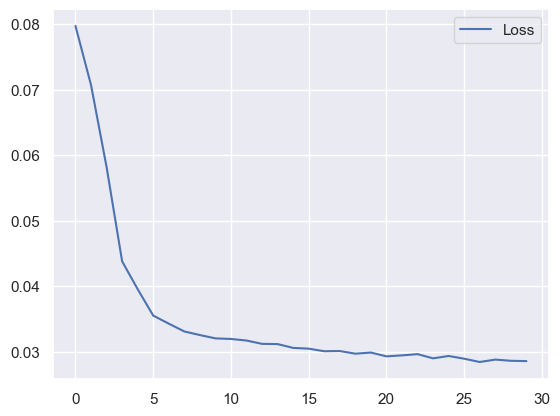

In [398]:
# plot history
plt.plot(history.history['loss'], label='Loss')
plt.legend()
plt.show()

In [399]:
y_hat = model.predict(x_test)

2023-06-30 13:04:52.745584: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-30 13:04:52.859767: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


384/384 [==============================] - 2s 4ms/step


In [400]:
y_hat.shape,y_test.shape


((12285, 1), (12285,))

In [401]:
#  y_test prediction has one month lag so we need re-match the date 
len([i[0] for i in y_hat][1:]),len(y_test[:-1])  


(12284, 12284)

In [405]:
y_hat_modified = y_hat  # discarding the first element
y_test_modified = y_test # discarding the last element

print(len(y_hat_modified), len(y_test_modified))  # check if lengths are now the same

pa = pd.DataFrame()
pa['Month'] = example_test.reset_index().month # also adjusted here
pa['Year'] = example_test.reset_index().year # and here
pa['Prediction'] = y_hat_modified
pa['Actual Values'] = y_test_modified
pa.head()


12285 12285


,Month,Year,Prediction,Actual Values
0,2,2018,0.086894,0.0
1,3,2018,0.087766,0.0
2,4,2018,0.088351,0.0
3,5,2018,0.088324,0.0
4,6,2018,0.088894,0.0


In [407]:
print(len(y_hat_modified))
print(len(y_test_modified))


12285
12285


In [408]:
pa['Actual Values'].sum()

1238.0

## Interpretation

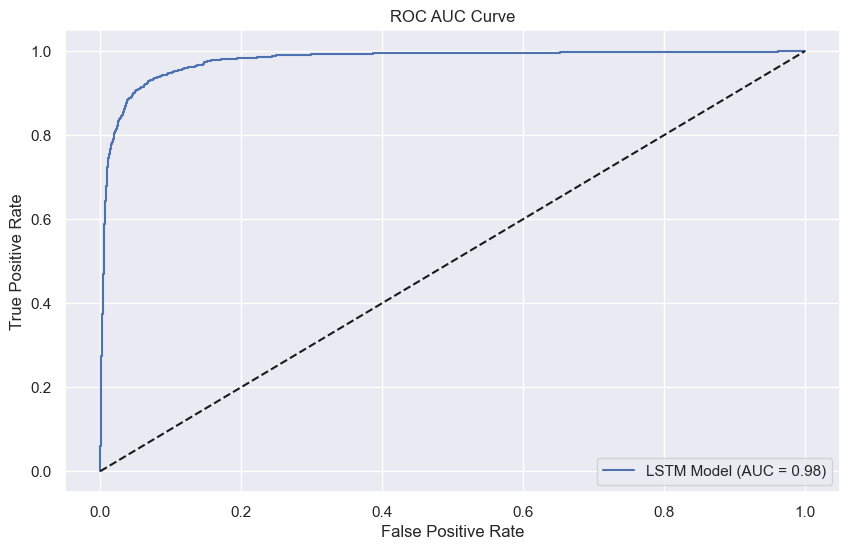

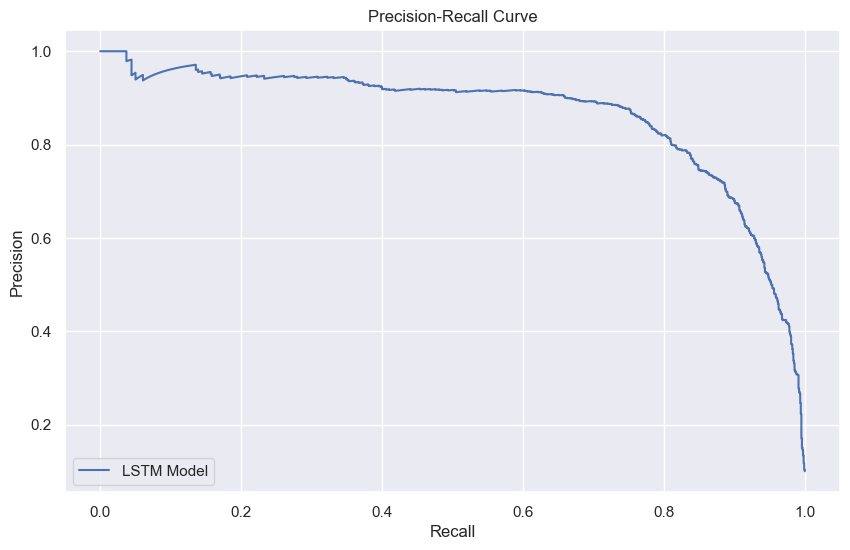

In [409]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, precision_recall_curve, auc


y_true = pa['Actual Values'].values
y_pred = pa['Prediction'].values


# Calculate ROC AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Calculate Precision and Recall scores
precision, recall, thresholds = precision_recall_curve(y_true, y_pred)

# Plot ROC AUC curve
plt.figure(figsize=(10, 6))
plt.plot(*roc_curve(y_true, y_pred)[:2], label='LSTM Model (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], 'k--')  # Random guessing line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC AUC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Plot Precision-Recall curve
plt.figure(figsize=(10, 6))
plt.plot(recall, precision, label='LSTM Model')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='lower left')
plt.grid(True)
plt.show()


In [410]:
thresholds

array([0.00585882, 0.00764562, 0.00828476, ..., 0.9995302 , 0.99957913,
       0.99960023], dtype=float32)

In [411]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# classes
y_pred_classes = (pa['Prediction'].values > 0.5).astype(int)

print("Confusion Matrix:\n", confusion_matrix(pa['Actual Values'].values, y_pred_classes))

print("\nClassification Report:\n", classification_report(pa['Actual Values'].values, y_pred_classes))

roc_auc_minority = roc_auc_score(pa['Actual Values'].values == 1, y_pred_classes)
print("\nROC AUC for minority class:", roc_auc_minority)

Confusion Matrix:
 [[10659   388]
 [  164  1074]]

Classification Report:
               precision    recall  f1-score   support

         0.0       0.98      0.96      0.97     11047
         1.0       0.73      0.87      0.80      1238

    accuracy                           0.96     12285
   macro avg       0.86      0.92      0.89     12285
weighted avg       0.96      0.96      0.96     12285


ROC AUC for minority class: 0.9162028068351806


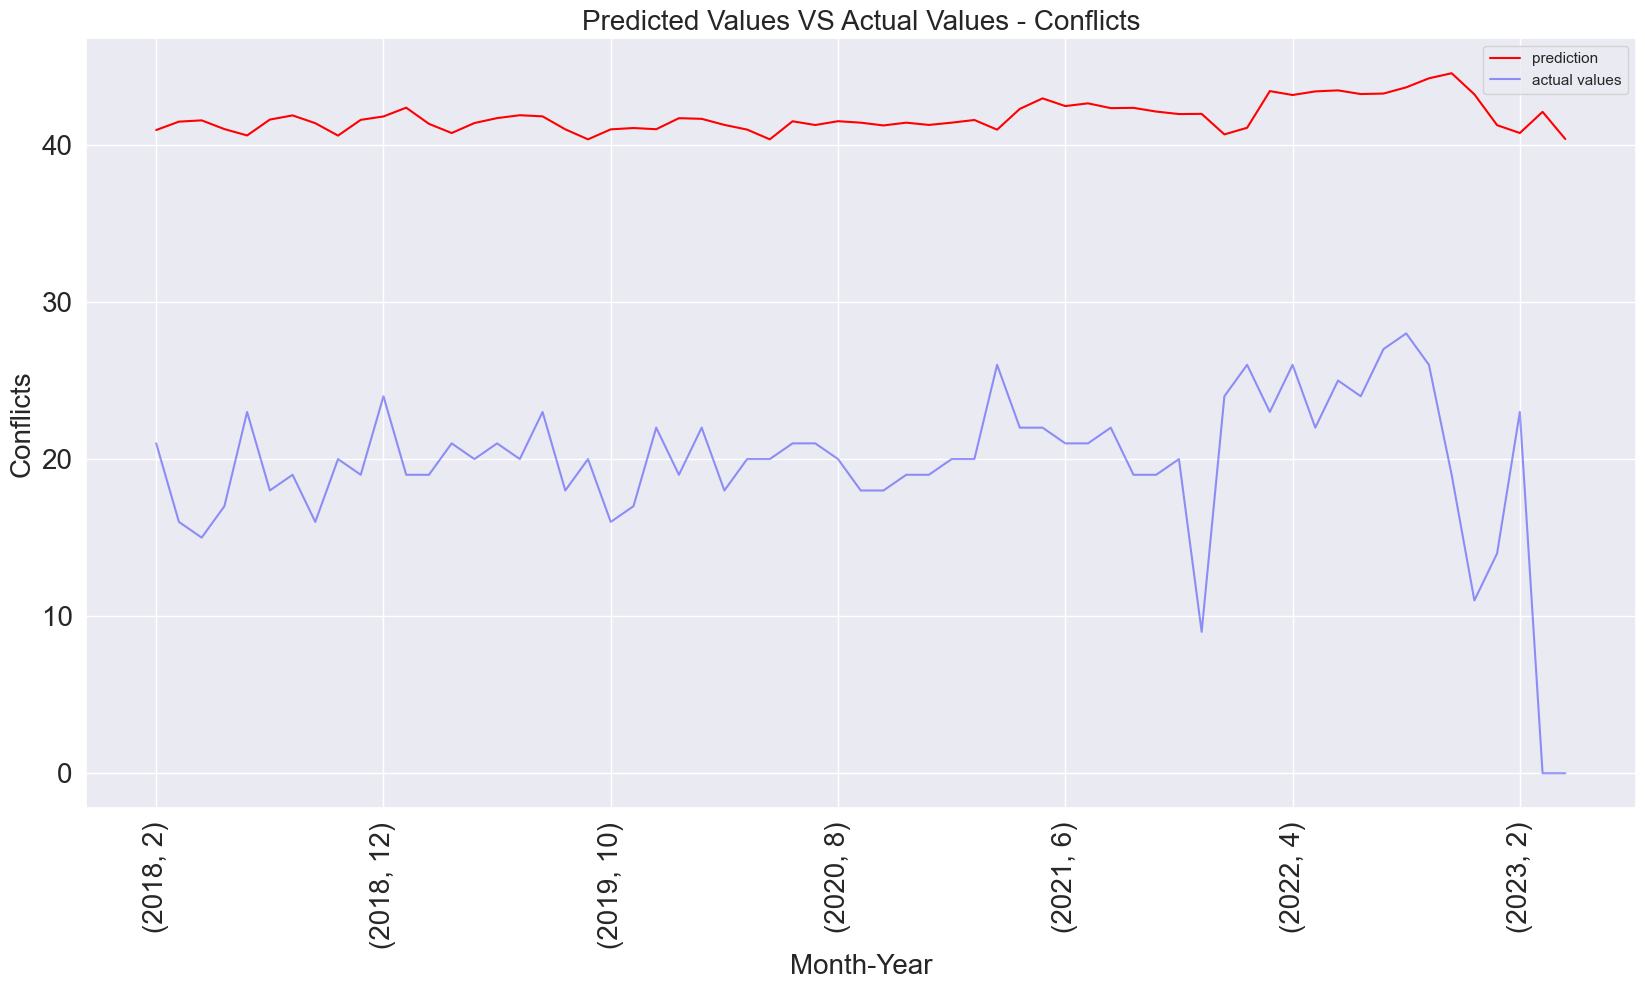

In [412]:
plt.figure(figsize=(20,10))
pa.groupby(['Year', 'Month'])['Prediction'].sum().plot(kind='line', label='prediction', color='red', alpha=1)
pa.groupby(['Year', 'Month'])['Actual Values'].sum().plot(kind='line', label='actual values', color='blue', alpha=0.4)
plt.xticks(rotation=90, size=20)
plt.yticks(size=20)

plt.ylabel('Conflicts', fontsize=20)
plt.xlabel('Month-Year', fontsize=20)
plt.title('Predicted Values VS Actual Values - Conflicts', fontsize=20)
plt.legend()


In [413]:
def reshape_test_data(test):
    target_column_index = test.shape[1] - 1
    # Frame as supervised learning and drop all time t columns except PM2.5
    reframed_test = series_to_supervised(test, 'isocode', target_column_index, 1, 1)
    # split into input and outputs
    test_values = reframed_test.values
    test_X, y_test = test_values[:, :-1], test_values[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_test = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    return x_test, y_test

2/2 [==============================] - 0s 101ms/step
Afghanistan - Precision: 1.0, Recall: 0.9193548387096774


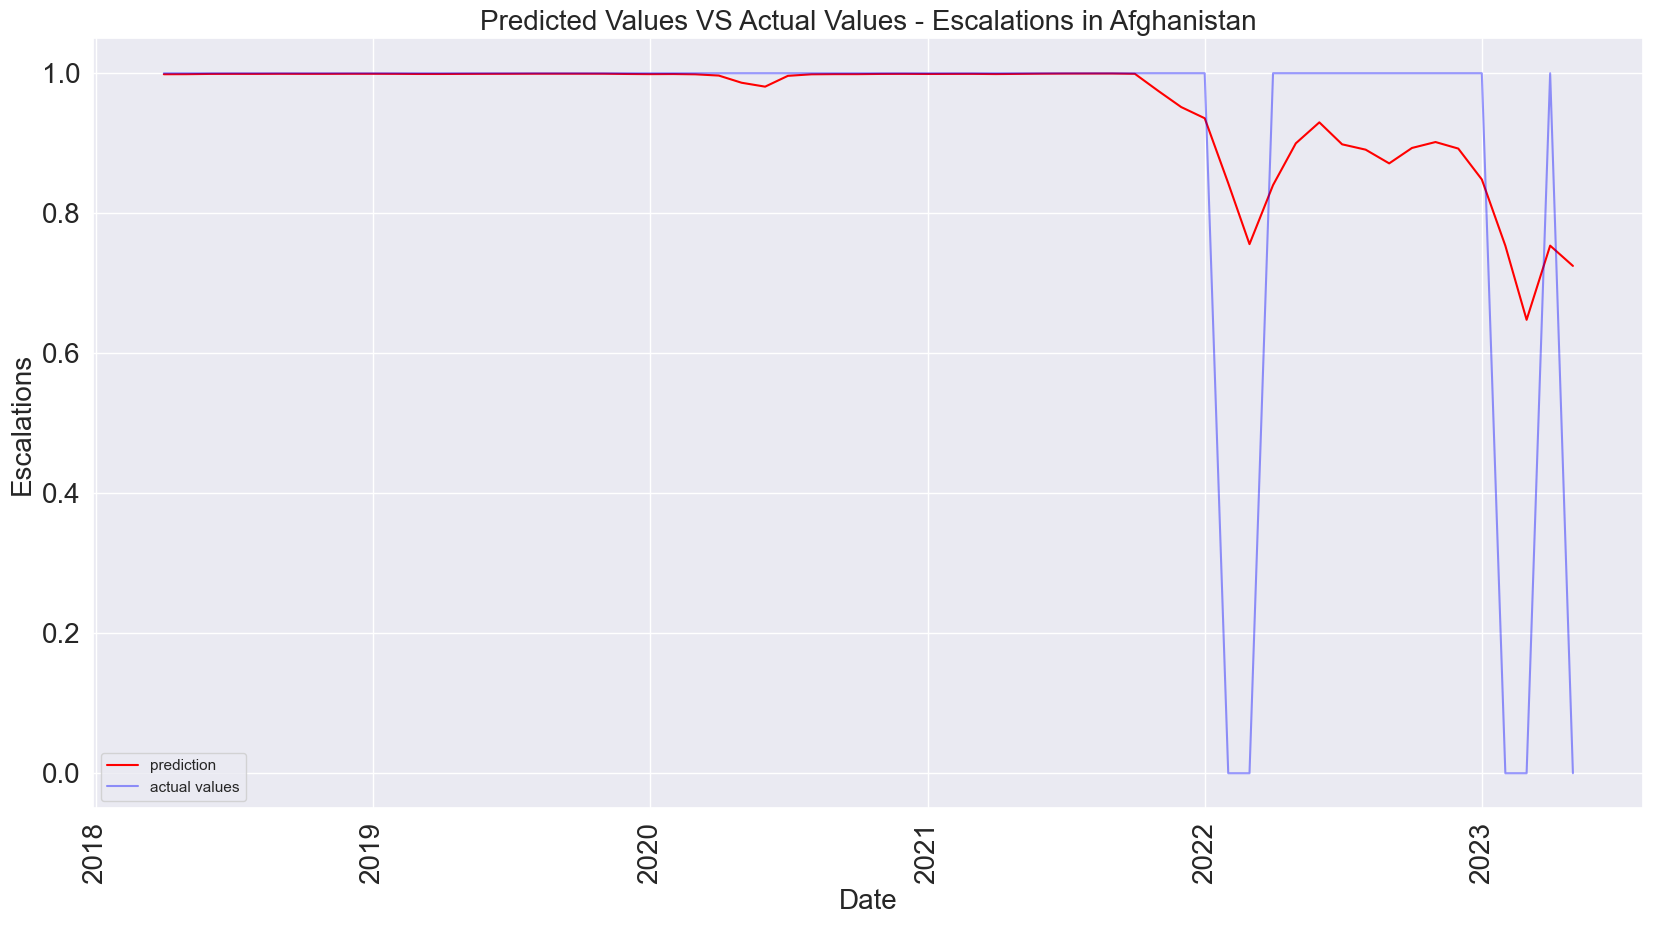

2/2 [==============================] - 0s 47ms/step
Somalia - Precision: 1.0, Recall: 0.967741935483871


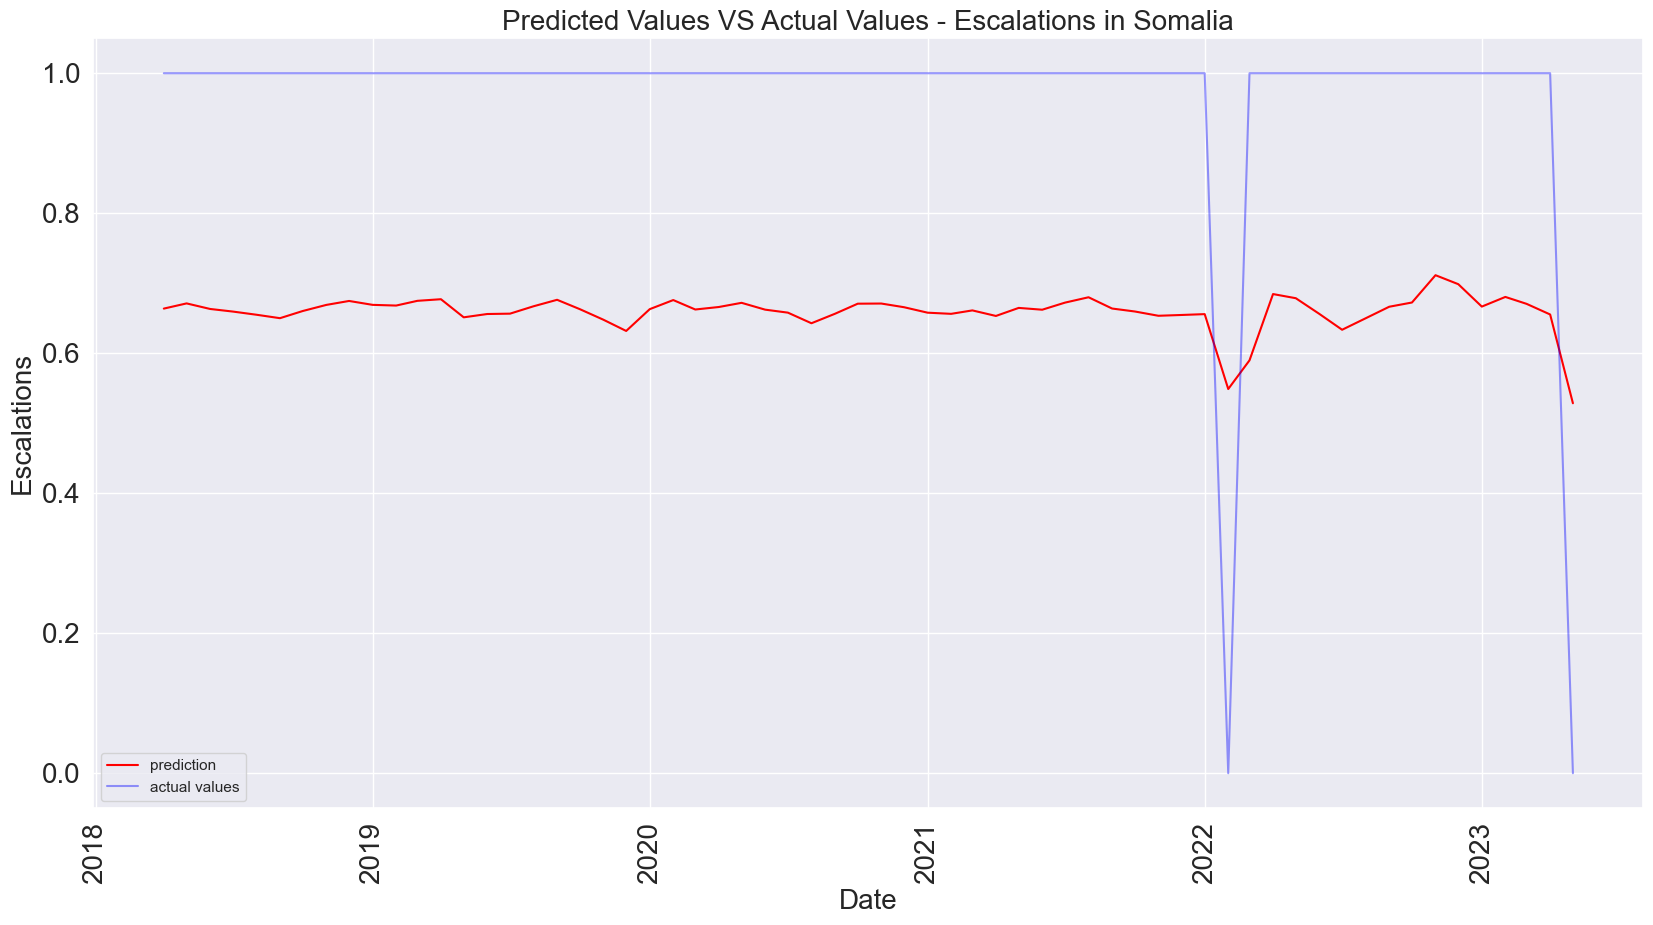

2/2 [==============================] - 0s 7ms/step
Sudan - Precision: 1.0, Recall: 0.7346938775510204


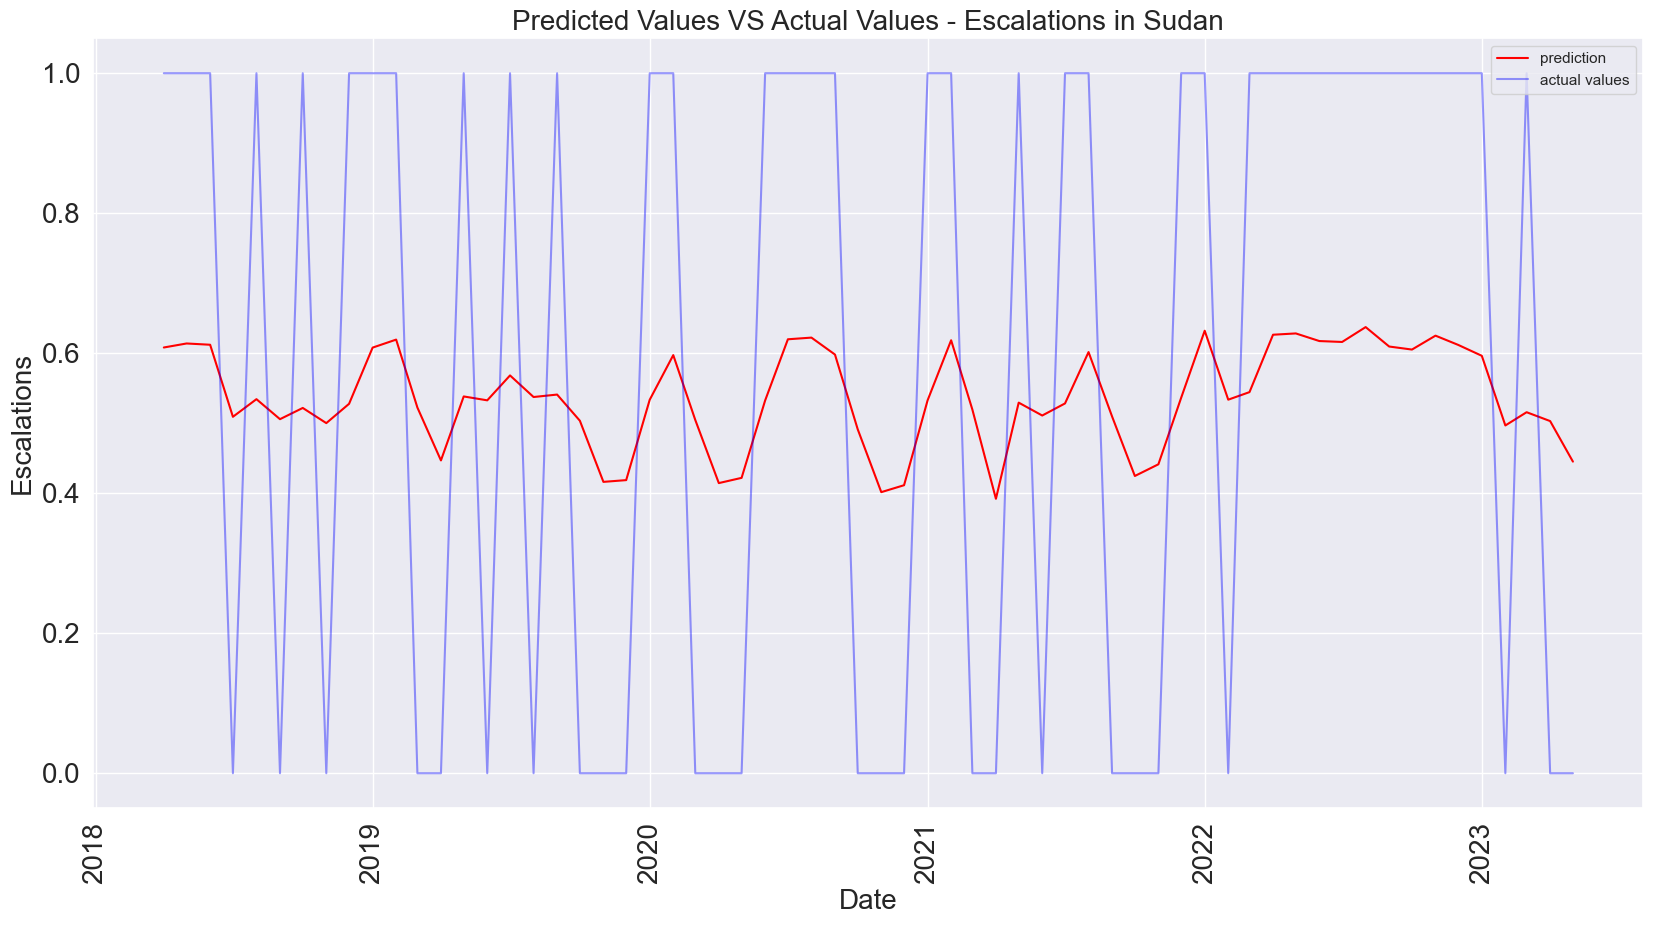

2/2 [==============================] - 0s 9ms/step
Iraq - Precision: 1.0, Recall: 0.9354838709677419


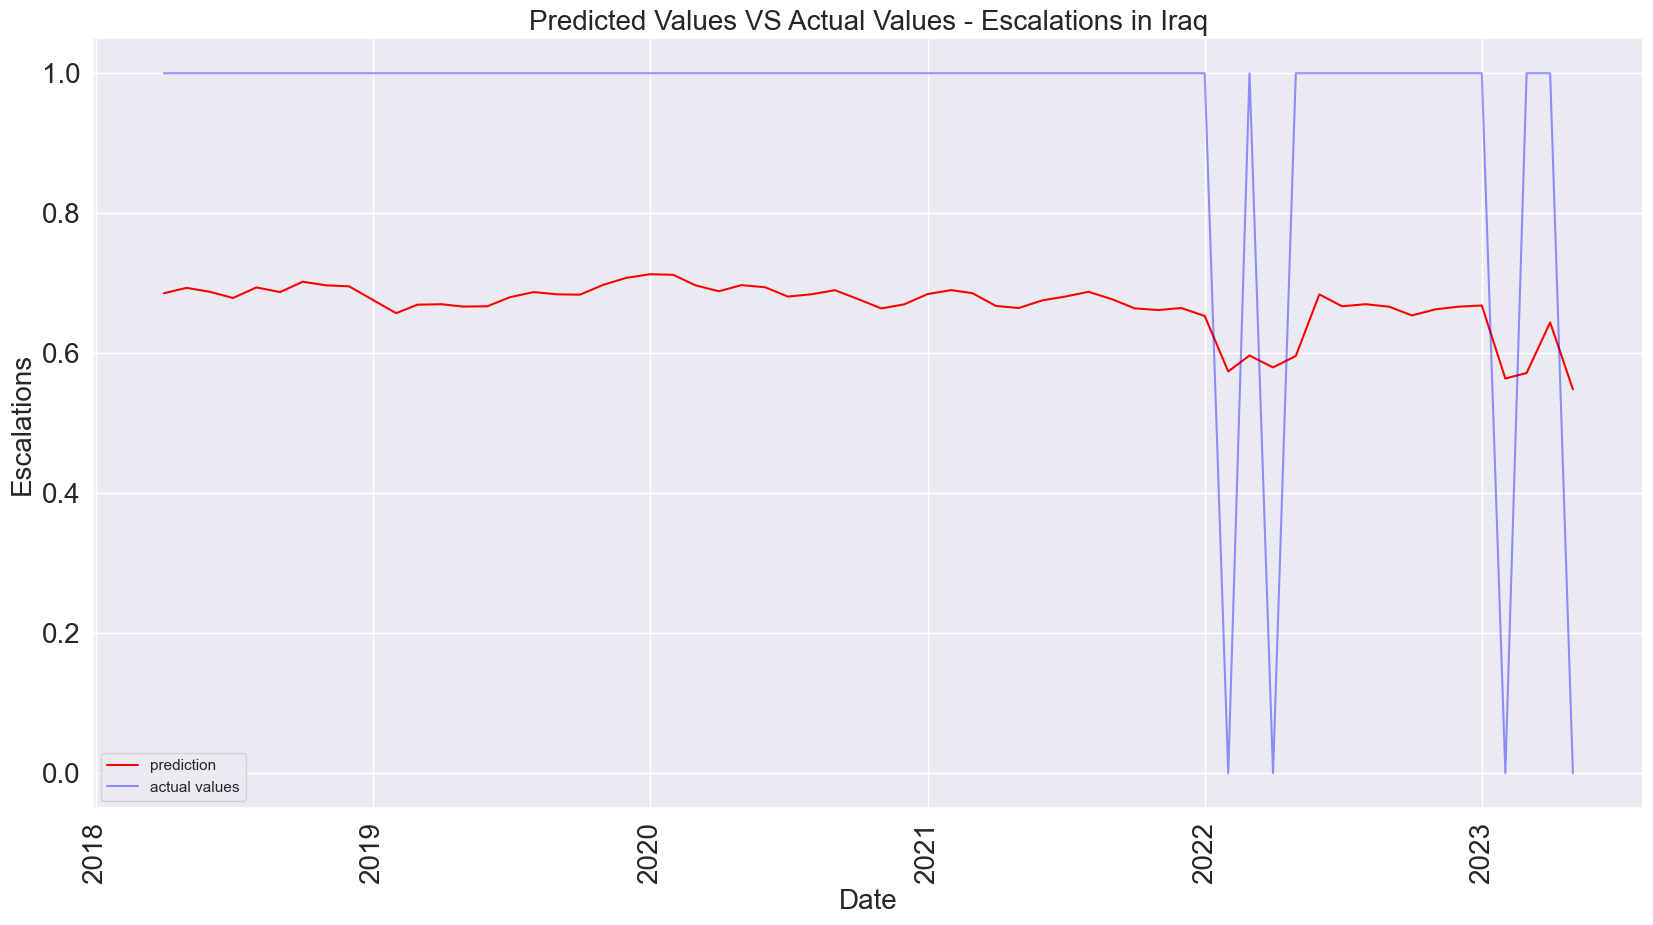

2/2 [==============================] - 0s 7ms/step
Congo, Dem. Rep. - Precision: 1.0, Recall: 0.9516129032258065


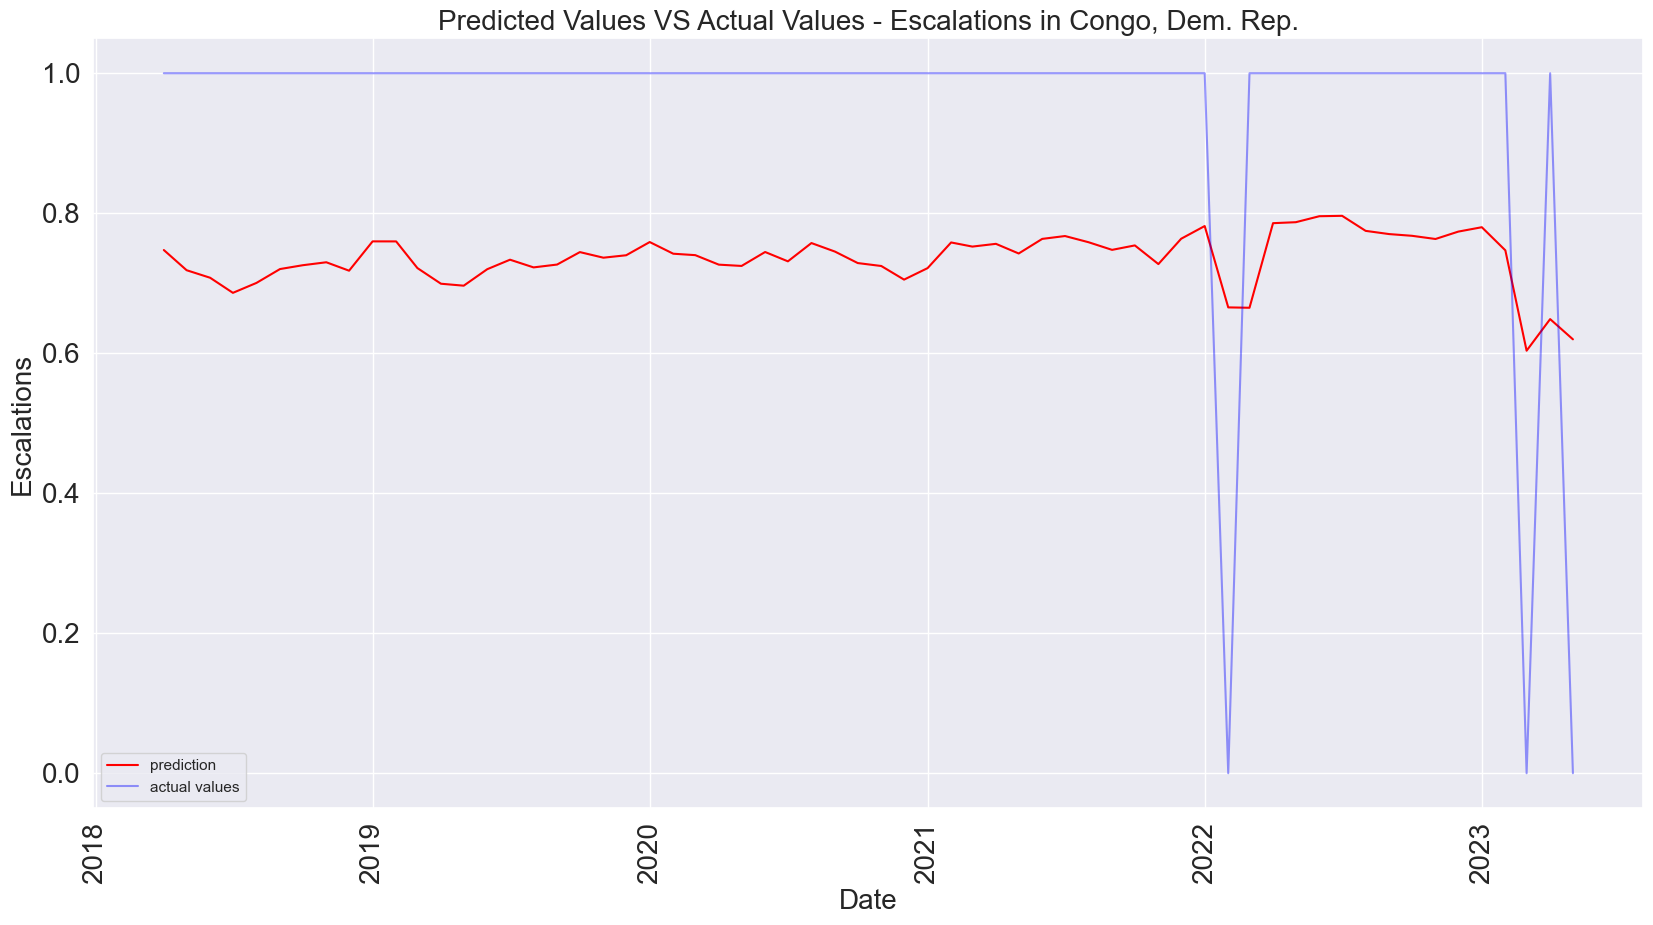

2/2 [==============================] - 0s 5ms/step
Colombia - Precision: 1.0, Recall: 0.6


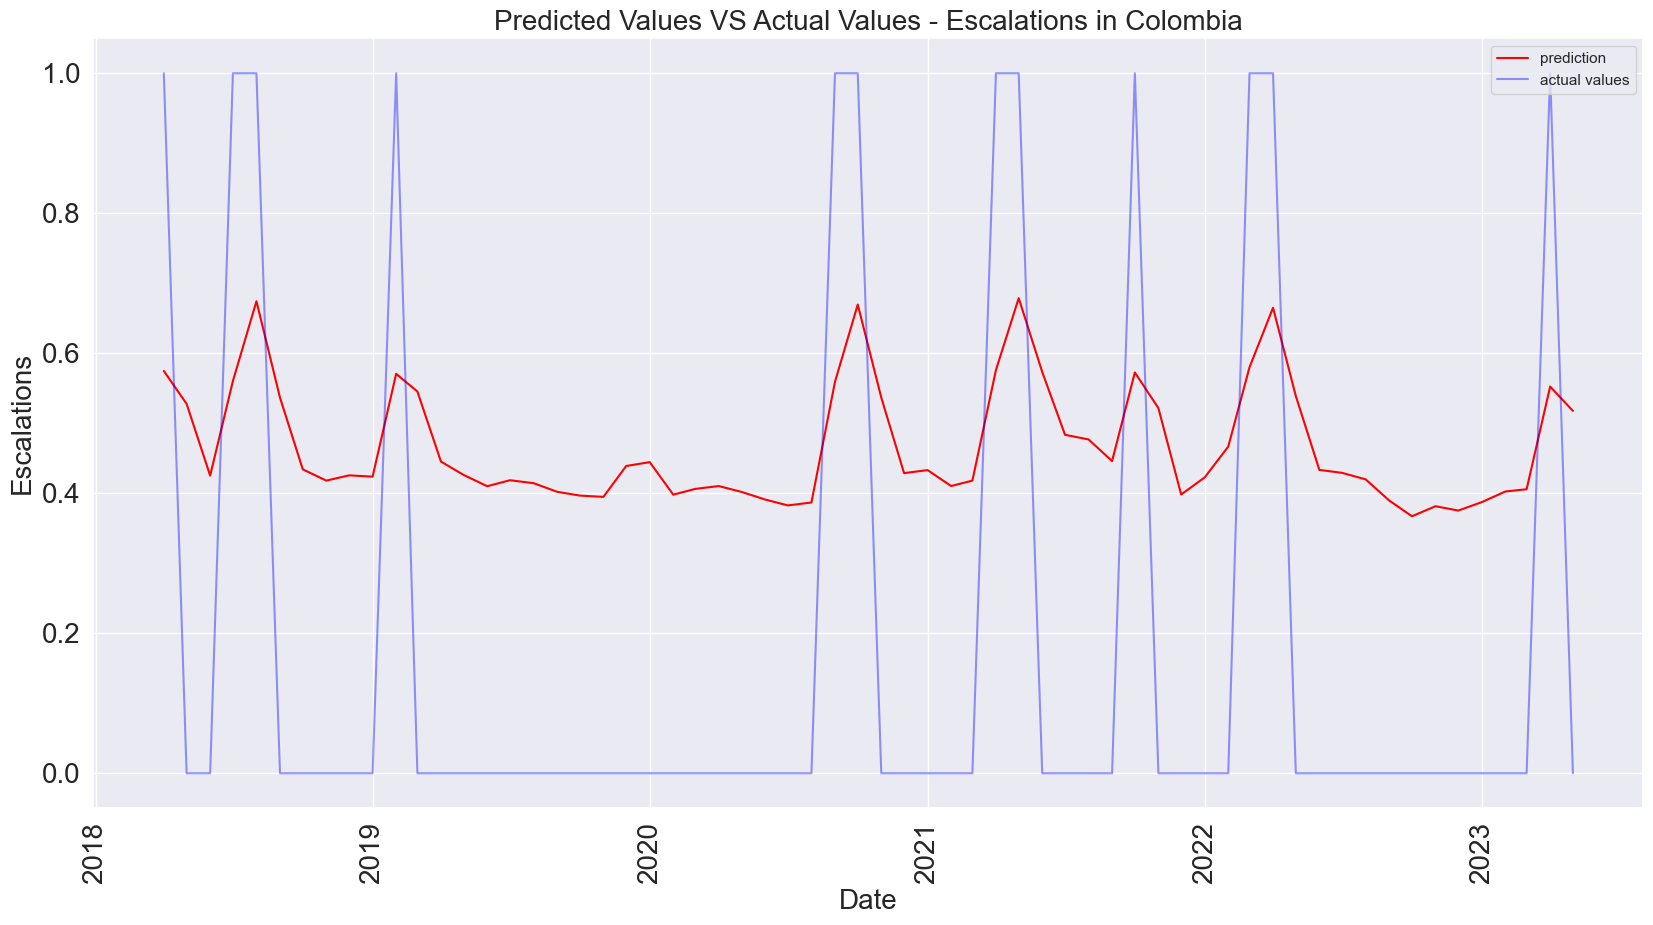

2/2 [==============================] - 0s 17ms/step
Israel - Precision: 1.0, Recall: 0.6111111111111112


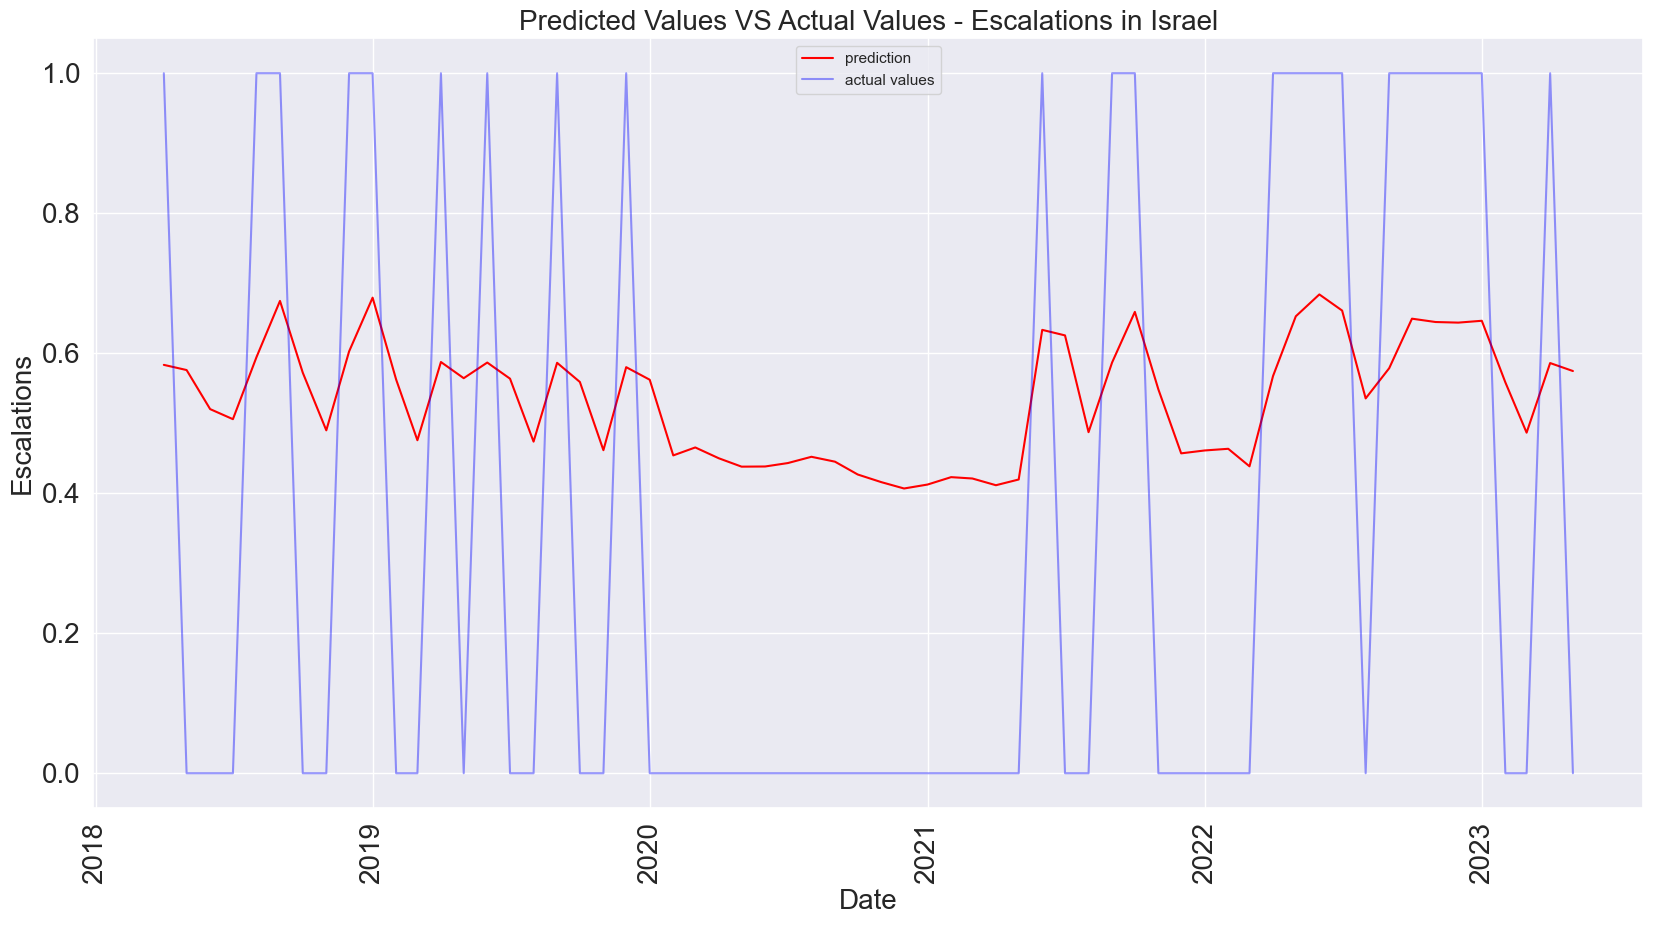

2/2 [==============================] - 0s 6ms/step
Algeria - Precision: 0.0, Recall: 0.0


/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/luisquinonespr/miniforge3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


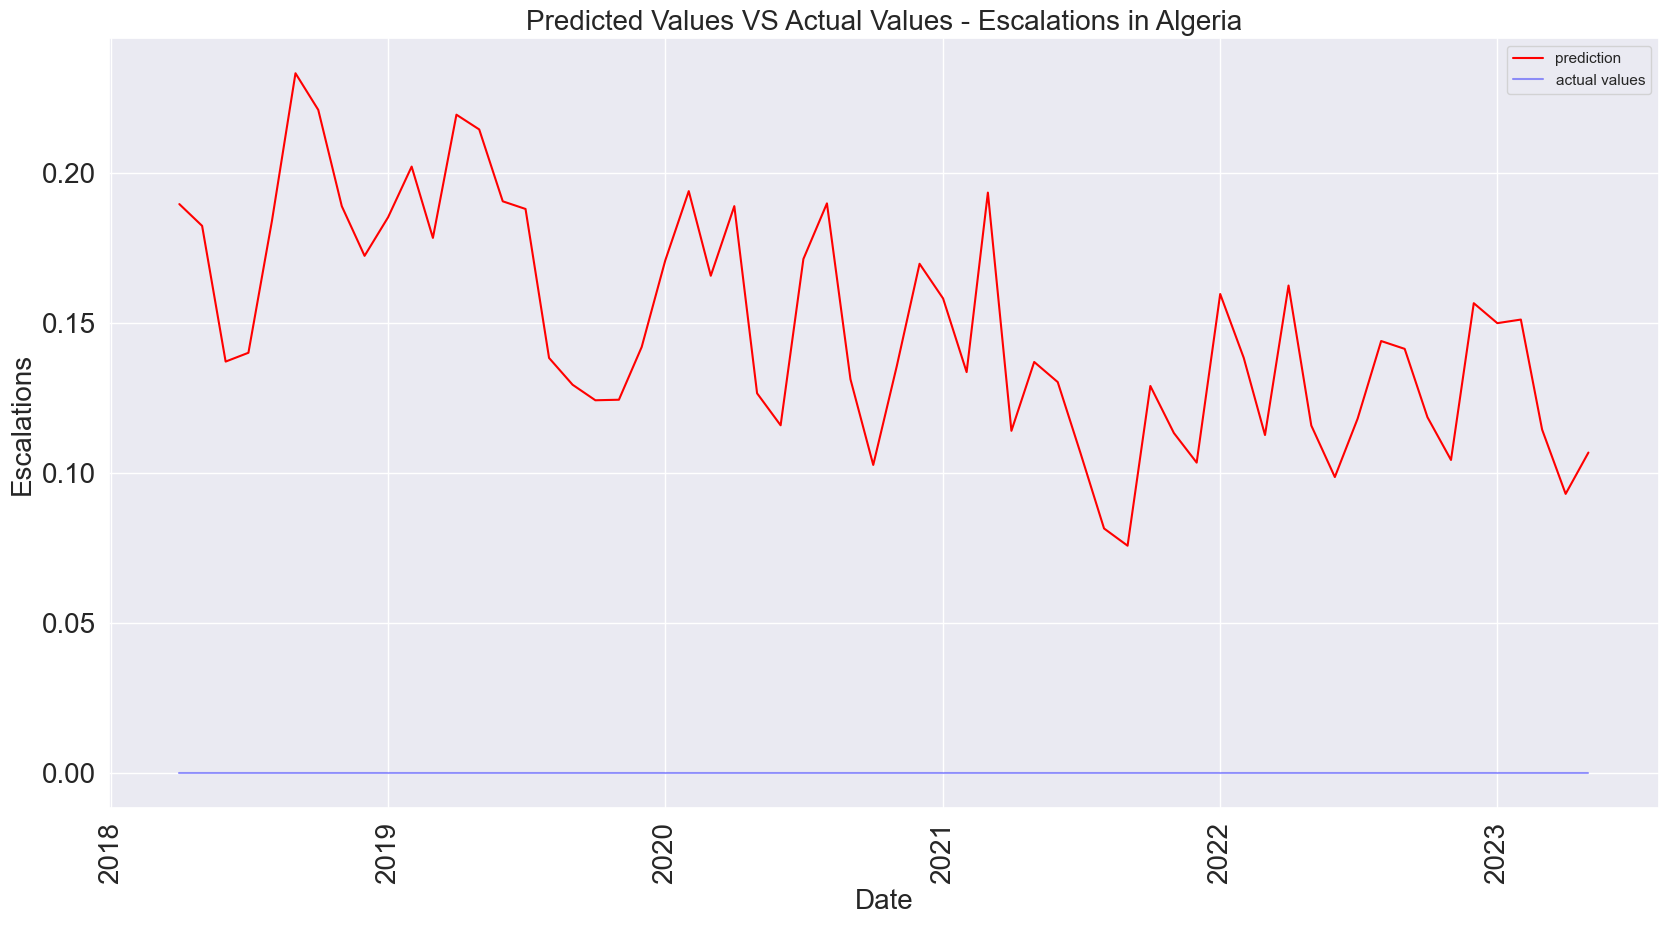

2/2 [==============================] - 0s 6ms/step
Burundi - Precision: 1.0, Recall: 0.6111111111111112


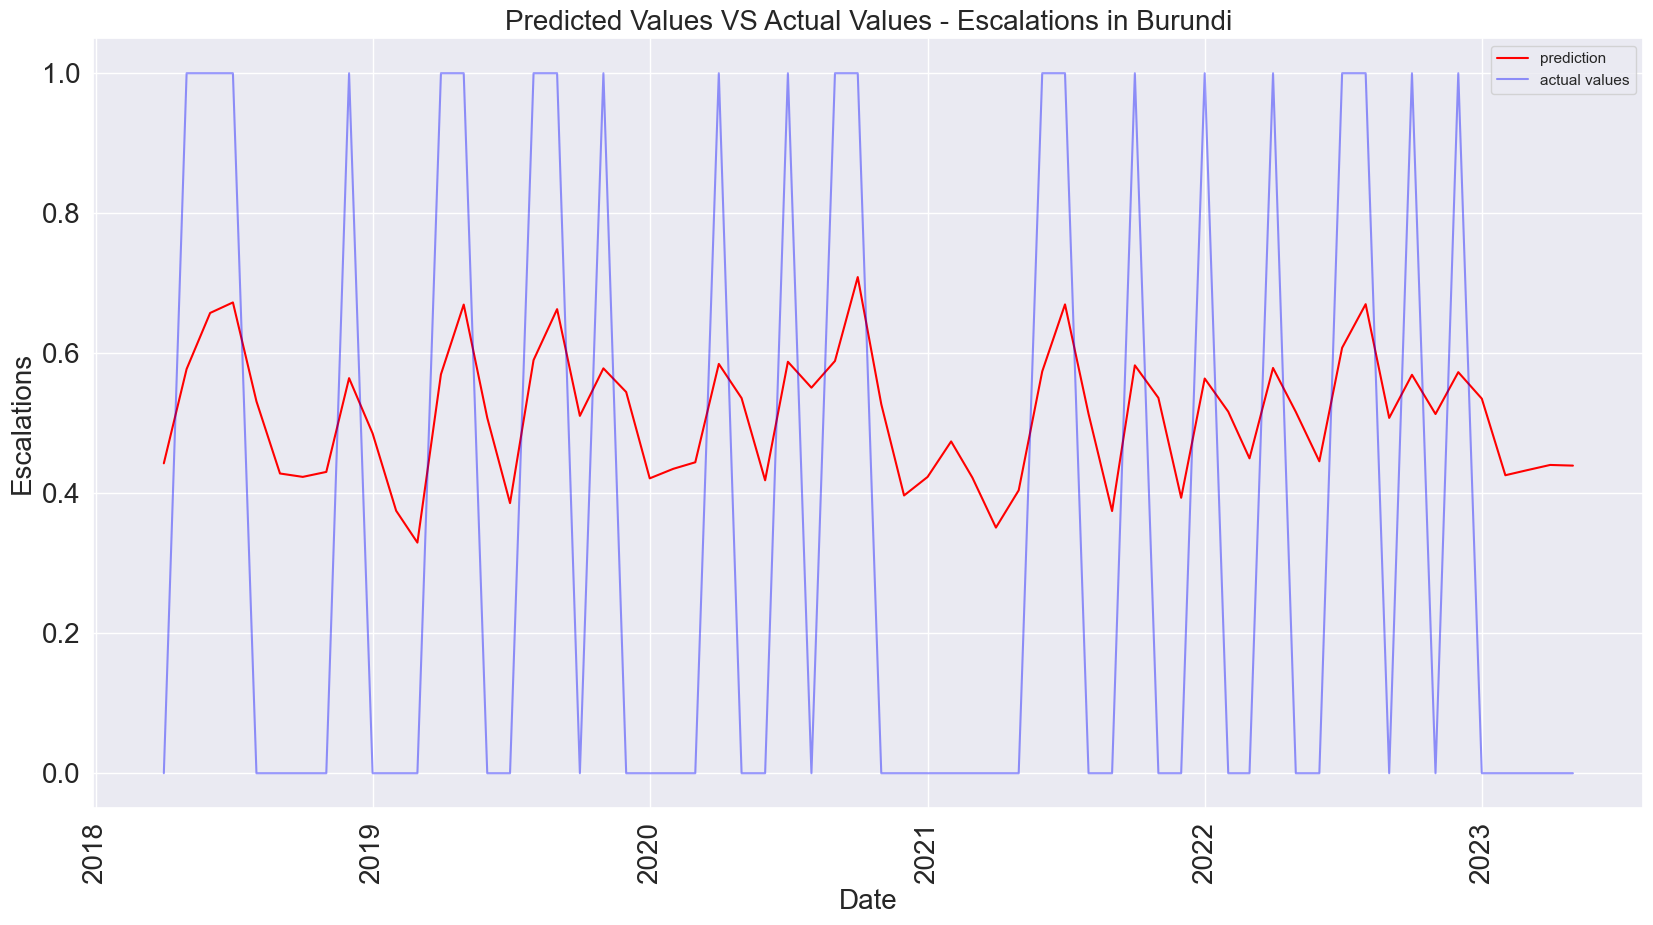

2/2 [==============================] - 0s 39ms/step
Sri Lanka - Precision: 1.0, Recall: 0.5


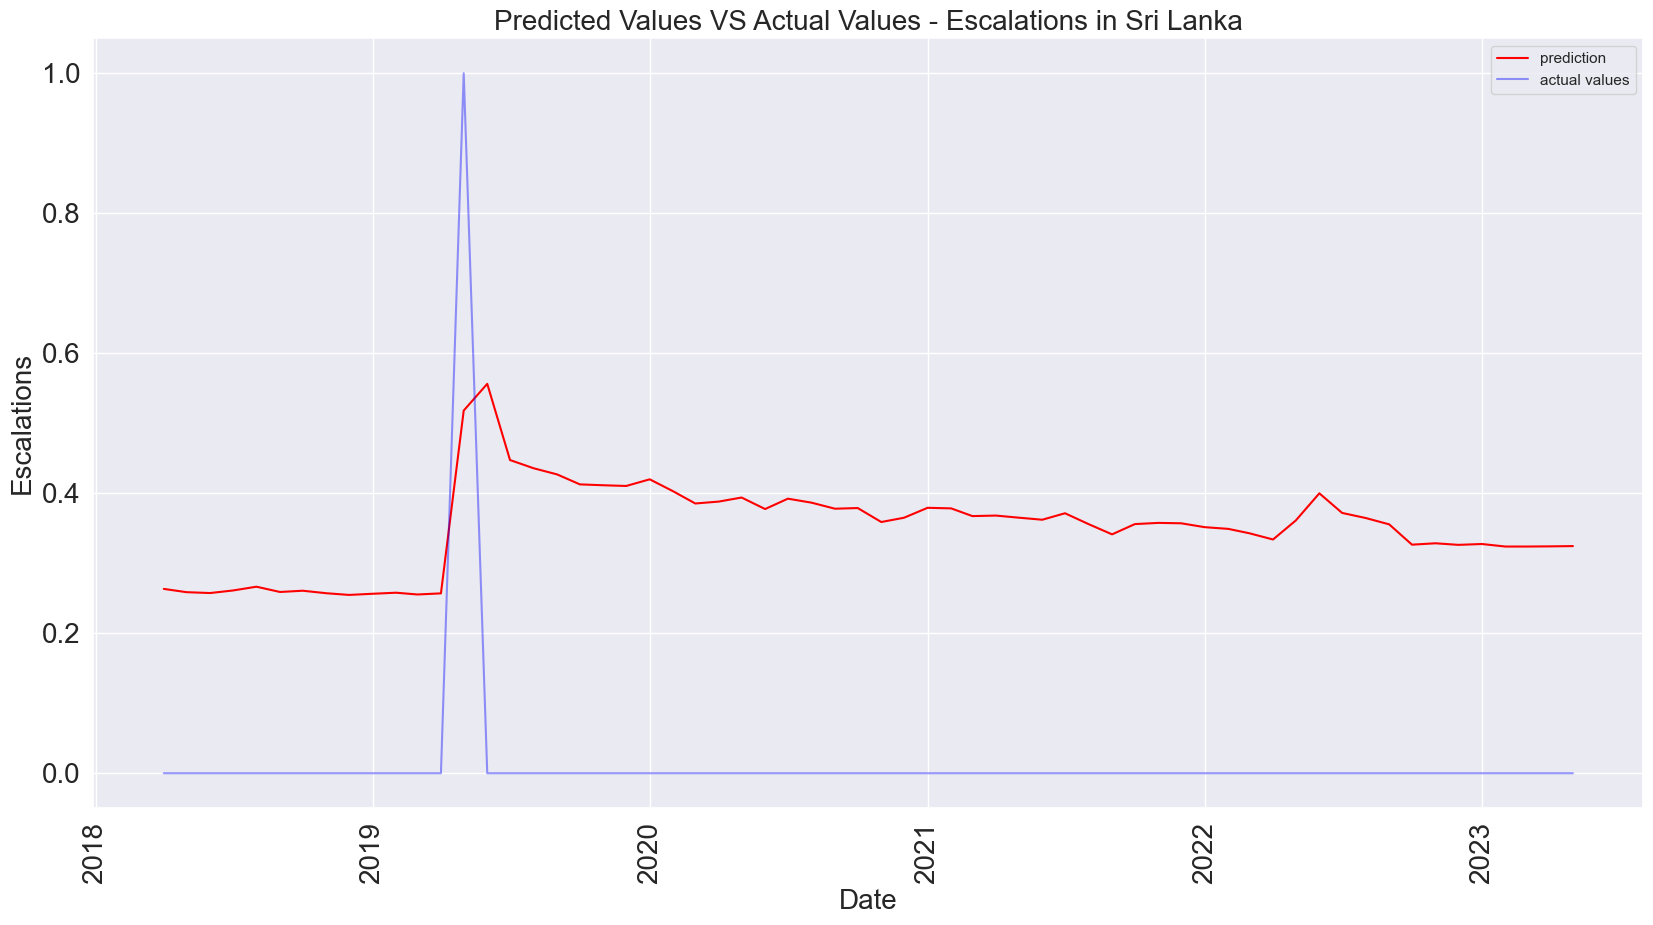

2/2 [==============================] - 0s 5ms/step
Nigeria - Precision: 1.0, Recall: 0.9032258064516129


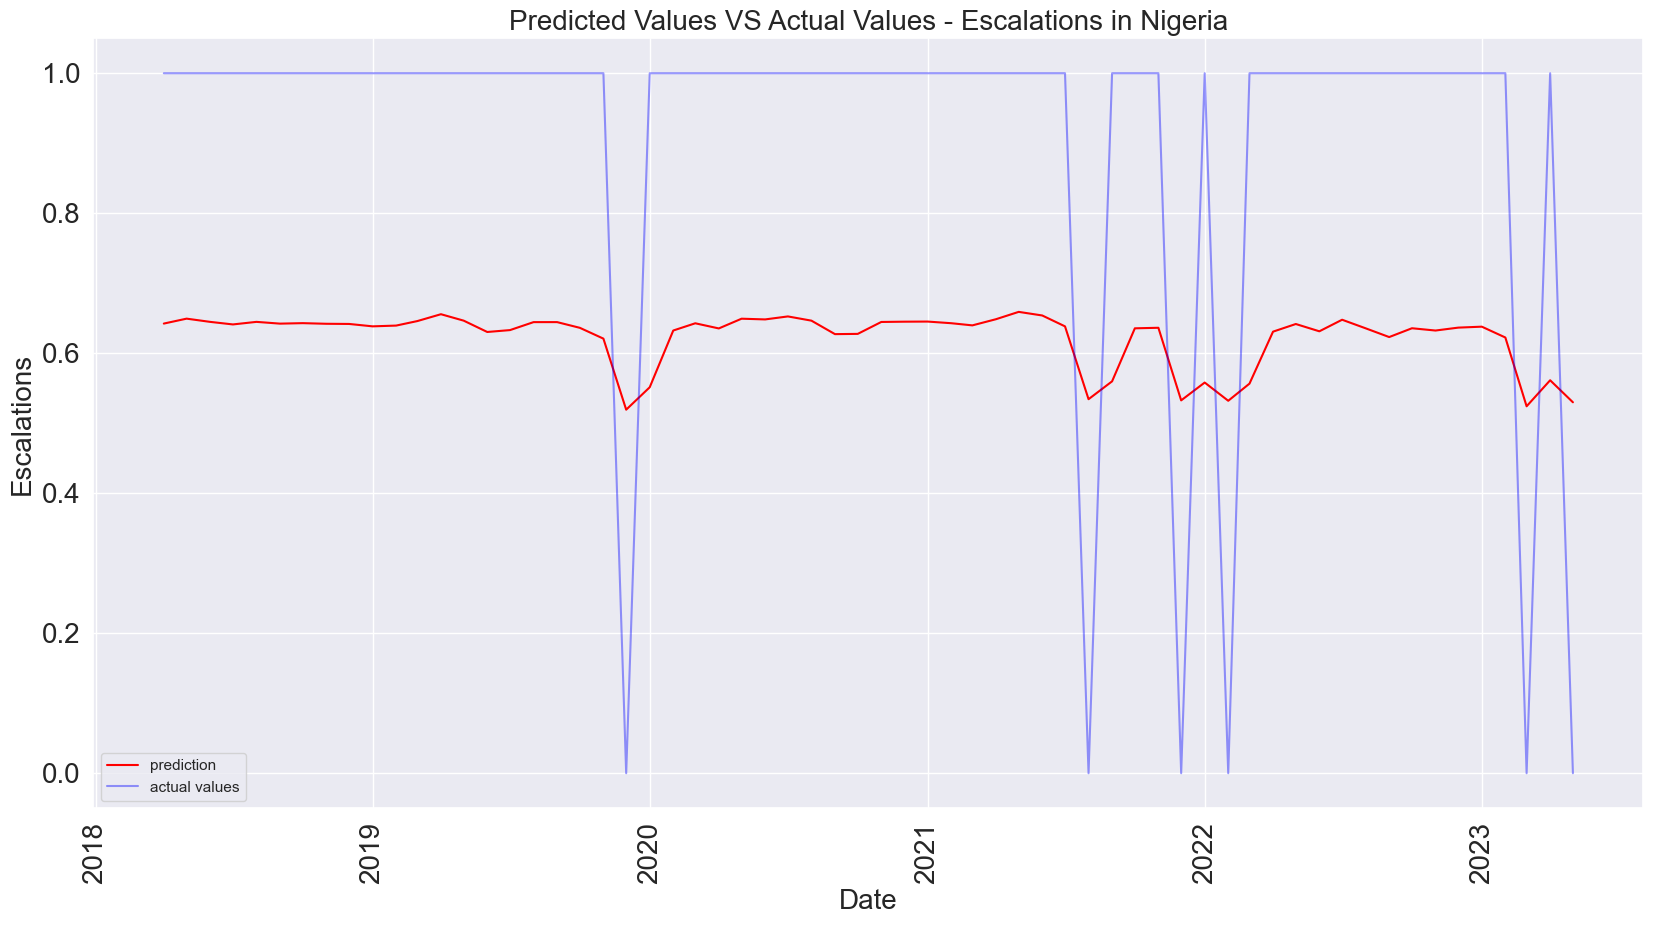

In [414]:
for country_name in top_10_country_names:
    # test data for this country
    country_data = test_copy[test_copy['country'] == country_name].copy()  

    # Re-encode 'country' column
    country_data['country'] = encoder.transform(country_data['country'])
    x_test_country, test_labels = reshape_test_data(country_data)

    # generate predictions
    y_pred = model.predict(x_test_country)

    # reshape y_pred and test_labels to 2D arrays
    y_pred = y_pred.reshape(-1, 1)
    test_labels = test_labels.reshape(-1, 1)
    # shifting predictions
    # shifting predictions
    y_hat_aligned = y_pred[1:].flatten()
    y_test_aligned = test_labels[:-1].flatten()
    y_hat_aligned_binary = (y_hat_aligned > 0.5).astype(int)

    # calculate errors
    precision = precision_score(y_test_aligned, y_hat_aligned_binary)
    recall = recall_score(y_test_aligned, y_hat_aligned_binary)


    print('{} - Precision: {}, Recall: {}'.format(country_name, recall, precision))

    # plot predicted vs actual
    pa = pd.DataFrame()
    pa['Date'] = pd.to_datetime(country_data.reset_index().year.astype(str) + '-' + country_data.reset_index().month.astype(str) + '-01')[-len(y_hat_aligned_binary):]
    pa['Prediction'] = y_hat_aligned
    pa['Actual Values'] = y_test_aligned  # Flatten to get a 1D array for plotting

    plt.figure(figsize=(20, 10))
    plt.plot(pa['Date'], pa['Prediction'], label='prediction', color='red', alpha=1)
    plt.plot(pa['Date'], pa['Actual Values'], label='actual values', color='blue', alpha=0.4)
    plt.xticks(rotation=90, size=20)
    plt.yticks(size=20)

    plt.ylabel('Escalations', fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.title('Predicted Values VS Actual Values - Escalations in {}'.format(country_name), fontsize=20)
    plt.legend()
    plt.show()
